In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import xgboost as xgb
import math
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Rataan Konsumsi Per Kapita Per Minggu

In [3]:
#Import Dataset
df_src = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '1ciROhgJvJK_6tfHZt_e0b6NlnJy38rr7EcIpagLUOvc' +
                   '/export?gid=1920198512&format=csv')
df_src.head()

,Jenis Bahan Makanan,Satuan,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Beras lokal/ketan,kg,1.740,1.797,1.755,1.733,1.721,1.675,1.642,1.626,1.631,1.668,1.565,1.551,1.504,1.505,1.569,1.560
1,Jagung basah dengan kulit,kg,0.046,0.024,0.012,0.018,0.012,0.011,0.011,0.013,0.029,0.035,0.026,0.029,0.039,0.050,0.034,0.032
2,Jagung pocelan/pipilan,kg,0.060,0.044,0.035,0.030,0.023,0.029,0.025,0.023,0.023,0.021,0.019,0.019,0.017,0.015,0.016,0.014
3,Ketela pohon,kg,0.134,0.147,0.106,0.097,0.111,0.069,0.067,0.066,0.069,0.073,0.122,0.091,0.084,0.093,0.119,0.106
4,Ketela rambat,kg,0.046,0.051,0.043,0.044,0.055,0.045,0.045,0.05,0.065,0.069,0.070,0.060,0.061,0.059,0.071,0.065


In [4]:
df_clean = df_src.melt(id_vars=['Jenis Bahan Makanan','Satuan'], var_name = 'Tahun', value_name='Rataan Konsumsi')
df_clean['Tahun'] = pd.to_datetime(df_clean['Tahun'], format='%Y-%m-%d')
df_clean.sample(10)

,Jenis Bahan Makanan,Satuan,Tahun,Rataan Konsumsi
7,Ikan dan udang diawetkan,ons,2007-01-01,0.523
2,Jagung pocelan/pipilan,kg,2007-01-01,0.06
339,Bawang merah,ons,2020-01-01,0.518
275,Beras lokal/ketan,kg,2018-01-01,1.551
167,Cabe rawit,ons,2013-01-01,0.244
51,Jagung basah dengan kulit,kg,2009-01-01,0.012
297,Kelapa,butir,2018-01-01,0.092
0,Beras lokal/ketan,kg,2007-01-01,1.74
151,Jagung basah dengan kulit,kg,2013-01-01,0.011
158,Daging sapi/kerbau,kg,2013-01-01,0.005


In [5]:
df_clean.rename(columns = {'Jenis Bahan Makanan': 'sektor_makanan',
                            'Satuan': 'satuan',
                            'Tahun': 'tanggal',
                            'Rataan Konsumsi': 'rataan_konsumsi_perkapita'}, inplace = True)
df_clean['rataan_konsumsi_perkapita'].replace('-', '0', inplace = True)
df_clean['rataan_konsumsi_perkapita'] = df_clean['rataan_konsumsi_perkapita'].astype('float64')
df_clean.set_index('tanggal', inplace = True)
df_clean.sample(10)

,sektor_makanan,satuan,rataan_konsumsi_perkapita
tanggal,,,
2014-01-01,Gula pasir,ons,1.229
2020-01-01,Jagung pocelan/pipilan,kg,0.015
2013-01-01,Bawang merah,ons,0.396
2020-01-01,Cabe merah,ons,0.032
2019-01-01,Gaplek,kg,0.002
2013-01-01,Kacang kedelai,kg,0.001
2019-01-01,Daging sapi/kerbau,kg,0.009
2016-01-01,Susu bubuk bayi,kg,0.013
2019-01-01,Kelapa,butir,0.090


In [6]:
df_clean.sektor_makanan.unique()

array(['Beras lokal/ketan', 'Jagung basah dengan kulit',
       'Jagung pocelan/pipilan', 'Ketela pohon', 'Ketela rambat',
       'Gaplek', 'Ikan dan udang segar 1', 'Ikan dan udang diawetkan',
       'Daging sapi/kerbau', 'Daging ayam ras/kampung',
       'Telur ayam ras/kampung 2', 'Telur itik/manila/asin',
       'Susu kental manis', 'Susu bubuk bayi', 'Bawang merah',
       'Bawang putih', 'Cabe merah', 'Cabe rawit', 'Kacang kedelai',
       'Tahu', 'Tempe', 'Minyak kelapa/jagung/goreng lainnya', 'Kelapa',
       'Gula pasir', 'Gula merah'], dtype=object)

In [7]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400 entries, 2007-01-01 to 2022-01-01
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sektor_makanan             400 non-null    object 
 1   satuan                     400 non-null    object 
 2   rataan_konsumsi_perkapita  400 non-null    float64
dtypes: float64(1), object(2)
memory usage: 12.5+ KB


In [8]:
df_clean.to_excel('data_konsumsi_per_kapita_minggu.xlsx')

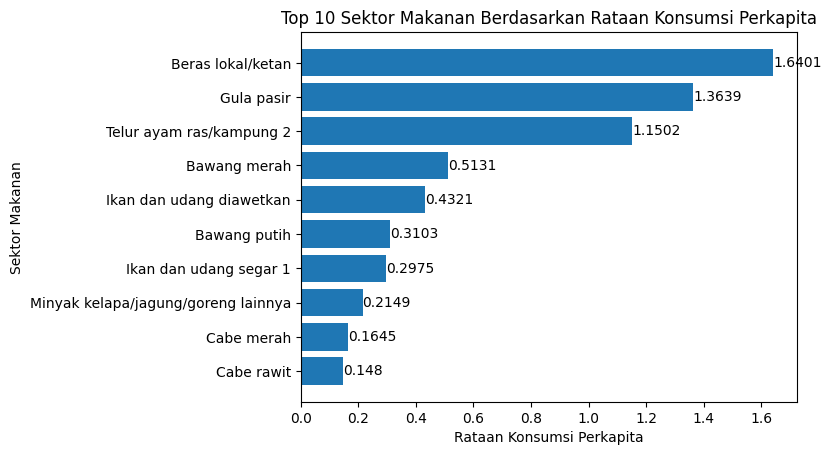

In [9]:
# Melakukan pengelompokan per sektor makanan dan menghitung rata-rata konsumsi per kapita
grouped = df_clean.groupby('sektor_makanan')['rataan_konsumsi_perkapita'].mean()

# Mengurutkan berdasarkan nilai rata-rata secara menurun
top_10 = grouped.sort_values().tail(10)

# Membuat horizontal bar chart
plt.barh(top_10.index, top_10.values)

# Menambahkan anotasi nilai pada setiap bar
for i, v in enumerate(top_10.values):
    plt.text(v, i, str(round(v, 4)), ha='left', va='center')

# Menambahkan judul dan label sumbu
plt.title('Top 10 Sektor Makanan Berdasarkan Rataan Konsumsi Perkapita')
plt.xlabel('Rataan Konsumsi Perkapita')
plt.ylabel('Sektor Makanan')

# Menampilkan plot dan legenda
plt.legend()
plt.show()

# Rataan Produksi Sayuran

In [10]:
#Import Dataset
df_sayur_2017 = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '1B8XpPin_-tkgxqC58_7ARNVLwlk3WEPe' +
                   '/export?gid=235583228&format=csv')
df_sayur_2017 = df_sayur_2017[['Provinsi', 'Bawang Merah (Ton)', 'Bawang Putih (Ton)', 'Cabai Rawit (Ton)']]
df_sayur_2017['tanggal'] = pd.Timestamp('2017-01-01')
df_sayur_2017.set_index('tanggal', inplace = True)
df_sayur_2017.rename(columns = {'Provinsi': 'provinsi',
                                'Bawang Merah (Ton)': 'bawang_merah_ton',
                                'Bawang Putih (Ton)': 'bawang_putih_ton',
                                'Cabai Rawit (Ton)': 'cabai_rawit_ton'}, inplace = True)
# df_sayur_2017['bawang_merah_per_kapita_per_minggu_ons'] = df_sayur_2017['bawang_merah_ton'] * 32000 / 261355500 / 52
# df_sayur_2017['bawang_putih_per_kapita_per_minggu_ons'] = df_sayur_2017['bawang_putih_ton'] * 32000 / 261355500 / 52
# df_sayur_2017['bawang_cabai_per_kapita_per_minggu_ons'] = df_sayur_2017['cabai_rawit_ton'] * 32000 / 261355500 / 52
df_sayur_2017.head()

,provinsi,bawang_merah_ton,bawang_putih_ton,cabai_rawit_ton
tanggal,,,,
2017-01-01,ACEH,8845.0,140.0,53800.0
2017-01-01,SUMATERA UTARA,16103.0,56.0,31727.0
2017-01-01,SUMATERA BARAT,95534.0,686.0,22872.0
2017-01-01,RIAU,262.0,2.0,10902.0
2017-01-01,JAMBI,8941.0,0.0,8352.0


In [11]:
df_sayur_2018 = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '1qXT9dIe9QCxMBwLV7_50oftEItS04dt4' +
                   '/export?gid=1157617013&format=csv')
df_sayur_2018 = df_sayur_2018[['Provinsi', 'Bawang Merah (Ton)', 'Bawang Putih (Ton)', 'Cabai Rawit (Ton)']]
df_sayur_2018['tanggal'] = pd.Timestamp('2018-01-01')
df_sayur_2018.set_index('tanggal', inplace = True)
df_sayur_2018.rename(columns = {'Provinsi': 'provinsi',
                                'Bawang Merah (Ton)': 'bawang_merah_ton',
                                'Bawang Putih (Ton)': 'bawang_putih_ton',
                                'Cabai Rawit (Ton)': 'cabai_rawit_ton'}, inplace = True)
# df_sayur_2018['bawang_merah_per_kapita_per_minggu_ons'] = df_sayur_2018['bawang_merah_ton'] * 32000 / 264161600 / 52
# df_sayur_2018['bawang_putih_per_kapita_per_minggu_ons'] = df_sayur_2018['bawang_putih_ton'] * 32000 / 264161600 / 52
# df_sayur_2018['bawang_cabai_per_kapita_per_minggu_ons'] = df_sayur_2018['cabai_rawit_ton'] * 32000 / 264161600 / 52
df_sayur_2018.head()

,provinsi,bawang_merah_ton,bawang_putih_ton,cabai_rawit_ton
tanggal,,,,
2018-01-01,ACEH,6818.00,32.00,62168.00
2018-01-01,SUMATERA UTARA,16337.00,59.00,39825.00
2018-01-01,SUMATERA BARAT,113865.00,1052.00,25178.00
2018-01-01,RIAU,186.00,-,12691.00
2018-01-01,JAMBI,10059.00,41.00,8273.00


In [12]:
df_sayur_2019 = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '1JJHk7y3NwztbFFwvUtbIn8pzfzaaEDwJ' +
                   '/export?gid=956942371&format=csv')
df_sayur_2019 = df_sayur_2019[['Provinsi', 'Bawang Merah (Ton)', 'Bawang Putih (Ton)', 'Cabai Rawit (Ton)']]
df_sayur_2019['tanggal'] = pd.Timestamp('2019-01-01')
df_sayur_2019.set_index('tanggal', inplace = True)
df_sayur_2019.rename(columns = {'Provinsi': 'provinsi',
                                'Bawang Merah (Ton)': 'bawang_merah_ton',
                                'Bawang Putih (Ton)': 'bawang_putih_ton',
                                'Cabai Rawit (Ton)': 'cabai_rawit_ton'}, inplace = True)
df_sayur_2019.head()

,provinsi,bawang_merah_ton,bawang_putih_ton,cabai_rawit_ton
tanggal,,,,
2019-01-01,ACEH,8840.0,288.0,61887.0
2019-01-01,SUMATERA UTARA,18072.0,975.0,49246.0
2019-01-01,SUMATERA BARAT,122399.0,1866.0,31782.0
2019-01-01,RIAU,507.0,0.0,8120.0
2019-01-01,JAMBI,9686.0,395.0,9880.0


In [13]:
df_sayur_2020 = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '1vEWLOjEQ0G6sMjavZ305i5jzRrfP1dfi' +
                   '/export?gid=2040948132&format=csv')
df_sayur_2020 = df_sayur_2020[['Provinsi', 'Bawang Merah (Ton)', 'Bawang Putih (Ton)', 'Cabai Rawit (Ton)']]
df_sayur_2020['tanggal'] = pd.Timestamp('2020-01-01')
df_sayur_2020.set_index('tanggal', inplace = True)
df_sayur_2020.rename(columns = {'Provinsi': 'provinsi',
                                'Bawang Merah (Ton)': 'bawang_merah_ton',
                                'Bawang Putih (Ton)': 'bawang_putih_ton',
                                'Cabai Rawit (Ton)': 'cabai_rawit_ton'}, inplace = True)
df_sayur_2020.head()

,provinsi,bawang_merah_ton,bawang_putih_ton,cabai_rawit_ton
tanggal,,,,
2020-01-01,ACEH,11246.0,796.0,64782.0
2020-01-01,SUMATERA UTARA,29222.0,1339.0,61160.0
2020-01-01,SUMATERA BARAT,153770.0,4906.0,33356.0
2020-01-01,RIAU,263.0,0.0,8627.0
2020-01-01,JAMBI,11977.0,502.0,13588.0


In [14]:
df_sayur_2021 = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '1Qqekvm98XumPJJOiKLmdp9brj8bJRMQw' +
                   '/export?gid=586030887&format=csv')
df_sayur_2021 = df_sayur_2021[['Provinsi', 'Bawang Merah (Ton)', 'Bawang Putih (Ton)', 'Cabai Rawit (Ton)']]
df_sayur_2021['tanggal'] = pd.Timestamp('2021-01-01')
df_sayur_2021.set_index('tanggal', inplace = True)
df_sayur_2021.rename(columns = {'Provinsi': 'provinsi',
                                'Bawang Merah (Ton)': 'bawang_merah_ton',
                                'Bawang Putih (Ton)': 'bawang_putih_ton',
                                'Cabai Rawit (Ton)': 'cabai_rawit_ton'}, inplace = True)
df_sayur_2021.head()

,provinsi,bawang_merah_ton,bawang_putih_ton,cabai_rawit_ton
tanggal,,,,
2021-01-01,ACEH,10136.0,30.00,51686.0
2021-01-01,SUMATERA UTARA,53962.0,805.00,78663.0
2021-01-01,SUMATERA BARAT,200366.0,1839.00,35118.0
2021-01-01,RIAU,329.0,-,6694.0
2021-01-01,JAMBI,13264.0,132.00,11526.0


In [15]:
df_sayur_2022 = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '19AEUVMv8aaSHfSe5wjk7ag9yyz6F7Xg9' +
                   '/export?gid=1761348625&format=csv')
df_sayur_2022 = df_sayur_2022[['Provinsi', 'Bawang Merah (Ton)', 'Bawang Putih (Ton)', 'Cabai Rawit (Ton)']]
df_sayur_2022['tanggal'] = pd.Timestamp('2022-01-01')
df_sayur_2022.set_index('tanggal', inplace = True)
df_sayur_2022.rename(columns = {'Provinsi': 'provinsi',
                                'Bawang Merah (Ton)': 'bawang_merah_ton',
                                'Bawang Putih (Ton)': 'bawang_putih_ton',
                                'Cabai Rawit (Ton)': 'cabai_rawit_ton'}, inplace = True)
df_sayur_2022.head()

,provinsi,bawang_merah_ton,bawang_putih_ton,cabai_rawit_ton
tanggal,,,,
2022-01-01,ACEH,10070.0,10.0,65308.0
2022-01-01,SUMATERA UTARA,64835.0,21.0,87012.0
2022-01-01,SUMATERA BARAT,207376.0,791.0,26656.0
2022-01-01,RIAU,195.0,0.0,7429.0
2022-01-01,JAMBI,16050.0,13.0,12429.0


In [16]:
data_produksi_sayur = pd.concat([df_sayur_2017, df_sayur_2018, df_sayur_2019, df_sayur_2020, df_sayur_2021, df_sayur_2022])
data_produksi_sayur = data_produksi_sayur.replace('-', np.nan)
data_produksi_sayur['bawang_merah_ton'] = data_produksi_sayur['bawang_merah_ton'].astype('float64')
data_produksi_sayur['bawang_putih_ton'] = data_produksi_sayur['bawang_putih_ton'].astype('float64')
data_produksi_sayur['cabai_rawit_ton'] = data_produksi_sayur['cabai_rawit_ton'].astype('float64')
data_produksi_sayur['provinsi'] = data_produksi_sayur['provinsi'].str.title()
data_produksi_sayur.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210 entries, 2017-01-01 to 2022-01-01
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   provinsi          210 non-null    object 
 1   bawang_merah_ton  209 non-null    float64
 2   bawang_putih_ton  176 non-null    float64
 3   cabai_rawit_ton   209 non-null    float64
dtypes: float64(3), object(1)
memory usage: 8.2+ KB


In [17]:
data_produksi_sayur.head()

,provinsi,bawang_merah_ton,bawang_putih_ton,cabai_rawit_ton
tanggal,,,,
2017-01-01,Aceh,8845.0,140.0,53800.0
2017-01-01,Sumatera Utara,16103.0,56.0,31727.0
2017-01-01,Sumatera Barat,95534.0,686.0,22872.0
2017-01-01,Riau,262.0,2.0,10902.0
2017-01-01,Jambi,8941.0,0.0,8352.0


In [18]:
data_produksi_sayur.to_csv('data_produksi_sayuran.csv')

# Rataan Produksi Padi - Beras

In [19]:
#Import Dataset
df_padi = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '1TWJbp6g_v5Bc1NAZLuD_16nMvgDaGE0I5wnW0cly0fQ' +
                   '/export?gid=62268740&format=csv')
df_padi.rename(columns = {'Provinsi': 'provinsi',
                               'Produksi Padi (ton)': 'produksi_padi_ton',
                               'Produksi Beras (ton)': 'produksi_beras_ton'}, inplace = True)
df_padi['tanggal'] = pd.Timestamp('2022-01-01')
df_padi.set_index('tanggal', inplace = True)
df_padi.head()

,provinsi,produksi_padi_ton,produksi_beras_ton
tanggal,,,
2022-01-01,Aceh,"1 533 138,08x","883 214,61x"
2022-01-01,Sumatera Utara,"2 131 672,38x","1 222 762,05x"
2022-01-01,Sumatera Barat,"1 422 873,77x","823 876,28x"
2022-01-01,Riau,"227 346,32x","130 475,02x"
2022-01-01,Jambi,"289 276,78x","167 338,97x"


In [20]:
for i in ['produksi_padi_ton', 'produksi_beras_ton']:
  df_padi[i] = df_padi[i].str.replace(r'.x$', '')
  df_padi[i] = df_padi[i].str.replace(" ","").str.replace(",",".")
  df_padi[i] = df_padi[i].astype('float64')

C:\Users\arfit\AppData\Local\Temp\ipykernel_22784\1400520386.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_padi[i] = df_padi[i].str.replace(r'.x$', '')


In [21]:
df_padi.head()

,provinsi,produksi_padi_ton,produksi_beras_ton
tanggal,,,
2022-01-01,Aceh,1533138.0,883214.6
2022-01-01,Sumatera Utara,2131672.3,1222762.0
2022-01-01,Sumatera Barat,1422873.7,823876.2
2022-01-01,Riau,227346.3,130475.0
2022-01-01,Jambi,289276.7,167338.9


In [22]:
df_padi.to_excel('data_produksi_padi.xlsx')

<Axes: xlabel='tanggal'>

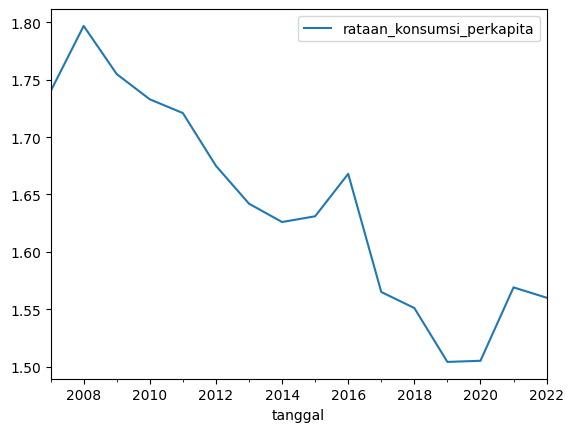

In [23]:
df_clean[df_clean['sektor_makanan'] == 'Beras lokal/ketan'].plot()

# Data Produksi Mengenai Padi (Start From 2018)

In [24]:
#Import Dataset
df_produksi_padi = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '1M5hdhwz0ZpWe2pfLZEtqZjyqT1WGSMb0' +
                   '/export?gid=1973296552&format=csv')
df_produksi_padi.rename(columns = {'Provinsi': 'provinsi'}, inplace = True)
df_produksi_padi = df_produksi_padi.melt(id_vars=['provinsi'], var_name = 'tanggal', value_name='produksi_padi')
df_produksi_padi['tanggal'] = pd.to_datetime(df_produksi_padi['tanggal'], format='%Y-%m-%d')
df_produksi_padi['provinsi'] = df_produksi_padi['provinsi'].str.title()
df_produksi_padi.set_index('tanggal', inplace = True)
df_produksi_padi.to_excel('data_produksi_padi.xlsx')
df_produksi_padi.head()

,provinsi,produksi_padi
tanggal,,
2018-01-01,Aceh,1861567.10
2018-01-01,Sumatera Utara,2108284.72
2018-01-01,Sumatera Barat,1483076.48
2018-01-01,Riau,266375.53
2018-01-01,Jambi,383045.74


In [25]:
#Import Dataset
df_luas_panen_padi = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '1M5hdhwz0ZpWe2pfLZEtqZjyqT1WGSMb0' +
                   '/export?gid=1793866025&format=csv')
df_luas_panen_padi.rename(columns = {'Provinsi': 'provinsi'}, inplace = True)
df_luas_panen_padi = df_luas_panen_padi.melt(id_vars=['provinsi'], var_name = 'tanggal', value_name='luas_panen_padi')
df_luas_panen_padi['tanggal'] = pd.to_datetime(df_luas_panen_padi['tanggal'], format='%Y-%m-%d')
df_luas_panen_padi['provinsi'] = df_luas_panen_padi['provinsi'].str.title()
df_luas_panen_padi.set_index('tanggal', inplace = True)
df_luas_panen_padi.to_excel('data_luas_panen_padi.xlsx')
df_luas_panen_padi.head()

,provinsi,luas_panen_padi
tanggal,,
2018-01-01,Aceh,329515.78
2018-01-01,Sumatera Utara,408176.45
2018-01-01,Sumatera Barat,313050.82
2018-01-01,Riau,71448.08
2018-01-01,Jambi,86202.68


In [26]:
#Import Dataset
df_produktivitas_padi = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '1M5hdhwz0ZpWe2pfLZEtqZjyqT1WGSMb0' +
                   '/export?gid=680125412&format=csv')
df_produktivitas_padi.rename(columns = {'Provinsi': 'provinsi'}, inplace = True)
df_produktivitas_padi = df_produktivitas_padi.melt(id_vars=['provinsi'], var_name = 'tanggal', value_name='produktivitas_padi')
df_produktivitas_padi['tanggal'] = pd.to_datetime(df_produktivitas_padi['tanggal'], format='%Y-%m-%d')
df_produktivitas_padi['provinsi'] = df_produktivitas_padi['provinsi'].str.title()
df_produktivitas_padi.set_index('tanggal', inplace = True)
df_produktivitas_padi.to_excel('data_produktivitas_padi.xlsx')
df_produktivitas_padi.head()

,provinsi,produktivitas_padi
tanggal,,
2018-01-01,Aceh,1861567.10
2018-01-01,Sumatera Utara,2108284.72
2018-01-01,Sumatera Barat,1483076.48
2018-01-01,Riau,266375.53
2018-01-01,Jambi,383045.74


# Data Produksi Perikanan

In [27]:
# Membaca data dari file CSV
df = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '1-8RByM8JxITOmk3982C2HNO1CI572WrG' +
                   '/export?gid=1970344091&format=csv', header = None)

df.columns = pd.MultiIndex.from_arrays([df.iloc[0], df.iloc[1]])
df = df.iloc[2:] # trim off the first 2 rows after we put them in the MultiIndex
df.head()

0             NaN Cakalang                             Tongkol                \
1        Provinsi     2017   2018   2019   2020   2021    2017   2018   2019   
2            ACEH    19072  31396  23892  38348  23399   34722  75142  27808   
3  SUMATERA UTARA    13928  25140  15107  14859  13892   16184  10398  11283   
4  SUMATERA BARAT      303  16312  16452  14995   9782   41308  21714  24111   
5            RIAU        -      0      0      -      -      12    459      0   
6           JAMBI        -      0      0      -      -       5      0      5   

0         ...   Udang                             Lainnya                   \
1   2020  ...    2017   2018   2019   2020   2021    2017    2018     2019   
2  78943  ...   18879   1869   1973   6932   3057  157395  157335    93076   
3  22735  ...  119135   8372  13953  13685  25876  563880  317075  1157457   
4  22137  ...   21430  26818  12453   4257   2953  145727  133813   156116   
5      -  ...    9633   4886   2783   4020   3689   98198  114677   111714   
6      -  ...   18673  10858  12197  16889  14467   25731   34751    32525   

0                  
1    2020    2021  
2  164640  139933  
3  368049  293695  
4  155987  156885  
5  107514  110136  
6   30601   31876  

[5 rows x 26 columns]

In [28]:
tmp = df.melt(id_vars=['Provinsi'], col_level=1)
tmp.head()

,Provinsi,1,value
0,ACEH,2017,19072
1,SUMATERA UTARA,2017,13928
2,SUMATERA BARAT,2017,303
3,RIAU,2017,-
4,JAMBI,2017,-


In [29]:
tmp['jenis_ikan'] = df.melt(col_level=0).dropna()[0].to_numpy()
tmp = tmp.rename({1: 'tanggal', 'value': 'nilai_produksi_ton'}, axis=1)
tmp.rename(columns = {'Provinsi': 'provinsi'}, inplace = True)
tmp['tanggal'] = pd.to_datetime(tmp['tanggal'], format='%Y-%m-%d')
tmp['provinsi'] = tmp['provinsi'].str.title()
tmp.set_index('tanggal', inplace = True)
tmp = tmp.replace('-', np.nan)
tmp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 850 entries, 2017-01-01 to 2021-01-01
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   provinsi            850 non-null    object
 1   nilai_produksi_ton  797 non-null    object
 2   jenis_ikan          850 non-null    object
dtypes: object(3)
memory usage: 26.6+ KB


In [30]:
tmp.head()

,provinsi,nilai_produksi_ton,jenis_ikan
tanggal,,,
2017-01-01,Aceh,19072,Cakalang
2017-01-01,Sumatera Utara,13928,Cakalang
2017-01-01,Sumatera Barat,303,Cakalang
2017-01-01,Riau,NaN,Cakalang
2017-01-01,Jambi,NaN,Cakalang


In [31]:
tmp.to_excel('produksi_ikan_5tahun.xlsx')

# Data Prevalensi Ketidakcukupan Pangan

In [32]:
# Membaca data dari file CSV
df_takcukup_makanan = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '1oO246Sm_eFLjgp7yydgk43N6LE-6mre3' +
                   '/export?gid=1106893671&format=csv')
df_takcukup_makanan.head()

,Provinsi,2017,2018,2019,2020,2021,2022
0,ACEH,8.40,8.68,9.41,8.58,6.90,10.98
1,SUMATERA UTARA,7.39,5.75,4.84,6.73,6.33,8.70
2,SUMATERA BARAT,5.53,5.45,4.90,5.86,6.02,7.31
3,RIAU,8.61,9.66,8.32,9.16,10.61,15.12
4,JAMBI,10.94,10.05,8.95,9.12,9.25,12.14


In [33]:
df_takcukup_makanan.rename(columns = {'Provinsi': 'provinsi'}, inplace = True)
df_takcukup_makanan = df_takcukup_makanan.melt(id_vars=['provinsi'], var_name = 'tanggal', value_name='nilai_prevalensi')
df_takcukup_makanan['tanggal'] = pd.to_datetime(df_takcukup_makanan['tanggal'], format='%Y-%m-%d')
df_takcukup_makanan['provinsi'] = df_takcukup_makanan['provinsi'].str.title()
df_takcukup_makanan.set_index('tanggal', inplace = True)
df_takcukup_makanan.to_excel('data_prevalensi_makanan.xlsx')
df_takcukup_makanan.head()

,provinsi,nilai_prevalensi
tanggal,,
2017-01-01,Aceh,8.40
2017-01-01,Sumatera Utara,7.39
2017-01-01,Sumatera Barat,5.53
2017-01-01,Riau,8.61
2017-01-01,Jambi,10.94


# Data Telur Ayam dan Itik

In [159]:
df = pd.read_excel('data_telur_ayam_itik.xlsx')

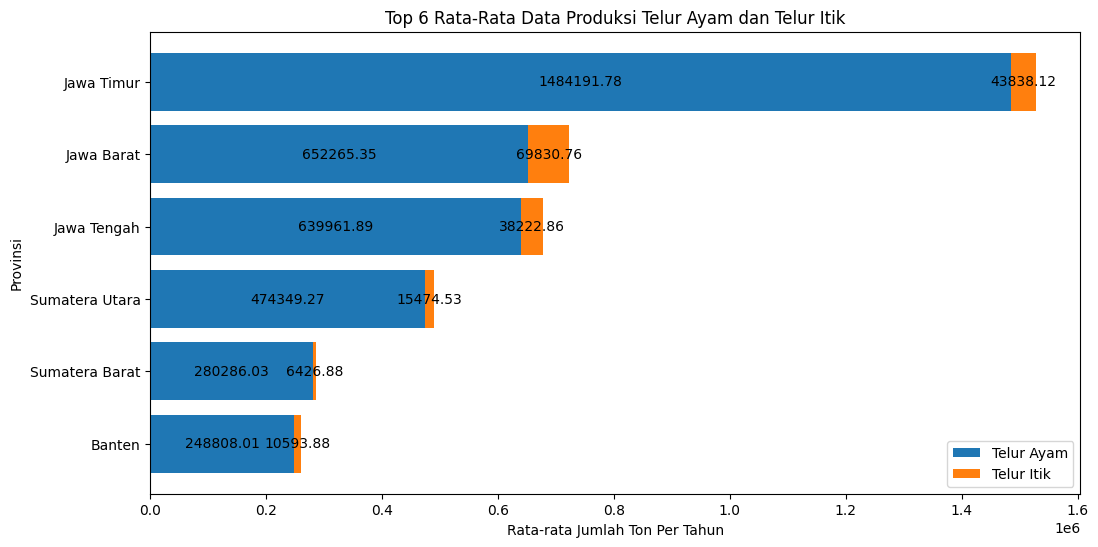

In [160]:
grouped = df.groupby('provinsi')[['telur_ayam_ton', 'telur_itik_ton']].mean()
top_6 = grouped.sort_values('telur_ayam_ton').tail(6)

fig, ax = plt.subplots(figsize=(12, 6))

plt.barh(top_6.index, top_6['telur_ayam_ton'], label='Telur Ayam')
plt.barh(top_6.index, top_6['telur_itik_ton'], left=top_6['telur_ayam_ton'], label='Telur Itik')

for i, (ayam, itik) in enumerate(zip(top_6['telur_ayam_ton'], top_6['telur_itik_ton'])):
    plt.text(ayam / 2, i, str(round(ayam, 2)), ha='center', va='center')
    plt.text(ayam + itik / 2, i, str(round(itik, 2)), ha='center', va='center')

plt.title('Top 6 Rata-Rata Data Produksi Telur Ayam dan Telur Itik')
plt.xlabel('Rata-rata Jumlah Ton Per Tahun')
plt.ylabel('Provinsi')
plt.legend()
plt.show()

# Clustering Produksi Sayuran Menurut Provinsi pada Tahun 2022

In [161]:
df = pd.read_excel('data_produksi_sayuran.xlsx')

In [162]:
filtered_df = df[df['tanggal'] == '2022']

In [163]:
filtered_df.dropna(inplace=True)

C:\Users\arfit\AppData\Local\Temp\ipykernel_20608\724713040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.dropna(inplace=True)


In [164]:
scaler = StandardScaler()

In [165]:
filtered_df[['bawang_merah_ton_T', 'bawang_putih_ton_T', 'cabai_rawit_ton_T']] = scaler.fit_transform(filtered_df[['bawang_merah_ton', 'bawang_putih_ton', 'cabai_rawit_ton']])

C:\Users\arfit\AppData\Local\Temp\ipykernel_20608\3975678463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['bawang_merah_ton_T', 'bawang_putih_ton_T', 'cabai_rawit_ton_T']] = scaler.fit_transform(filtered_df[['bawang_merah_ton', 'bawang_putih_ton', 'cabai_rawit_ton']])
C:\Users\arfit\AppData\Local\Temp\ipykernel_20608\3975678463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['bawang_merah_ton_T', 'bawang_putih_ton_T', 'cabai_rawit_ton_T']] = scaler.fit_transform(filtered

In [166]:
def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)
    
    fig = plt.subplots(figsize = (10,5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

In [167]:
def plot_clustered_scatter(x, y, labels):
    unique_labels = labels.unique()

    for label in unique_labels:
        cluster_x = x[labels == label]
        cluster_y = y[labels == label]
        plt.scatter(cluster_x, cluster_y, label=f'Cluster {label}')

    plt.legend()

c:\Users\arfit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\arfit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\arfit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\arfit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

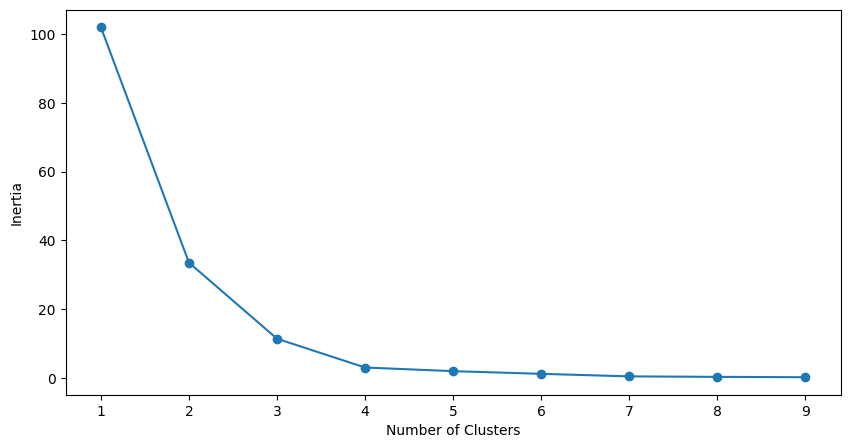

In [168]:
optimise_k_means(filtered_df[['bawang_merah_ton_T', 'bawang_putih_ton_T', 'cabai_rawit_ton_T']], 10)

In [169]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(filtered_df[['bawang_merah_ton_T', 'bawang_putih_ton_T', 'cabai_rawit_ton_T']])
filtered_df['cluster_kmeans_'] = kmeans.labels_

c:\Users\arfit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\arfit\AppData\Local\Temp\ipykernel_20608\3943848002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cluster_kmeans_'] = kmeans.labels_


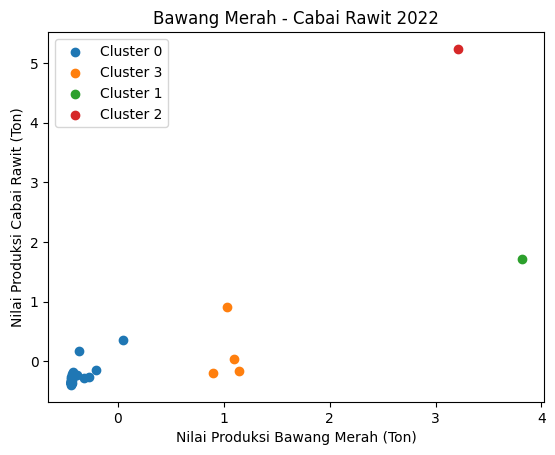

In [170]:
plot_clustered_scatter(filtered_df['bawang_merah_ton_T'], filtered_df['cabai_rawit_ton_T'], filtered_df['cluster_kmeans_'])

plt.xlabel('Nilai Produksi Bawang Merah (Ton)')
plt.ylabel('Nilai Produksi Cabai Rawit (Ton)')
plt.title('Bawang Merah - Cabai Rawit 2022')

plt.show()

In [171]:
cluster_counts = filtered_df.groupby(['provinsi', 'cluster_kmeans_']).size().unstack()
cluster_counts

cluster_kmeans_,0,1,2,3
provinsi,,,,
Aceh,1.0,NaN,NaN,NaN
Bali,1.0,NaN,NaN,NaN
Banten,1.0,NaN,NaN,NaN
Bengkulu,1.0,NaN,NaN,NaN
Di Yogyakarta,1.0,NaN,NaN,NaN
Dki Jakarta,1.0,NaN,NaN,NaN
Gorontalo,1.0,NaN,NaN,NaN
Jambi,1.0,NaN,NaN,NaN
Jawa Barat,NaN,NaN,NaN,1.0


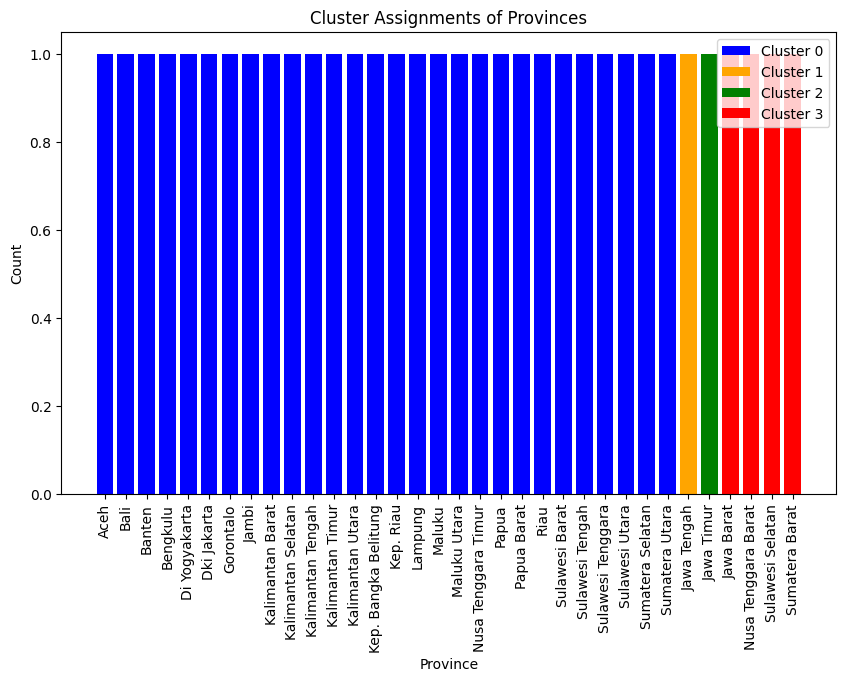

In [172]:
# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each cluster
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Iterate over the clusters
for i, cluster_label in enumerate(cluster_counts.columns):
    cluster_data = cluster_counts[cluster_label].dropna()
    ax.bar(cluster_data.index, cluster_data.values, color=colors[i], label=f'Cluster {cluster_label}')

ax.set_xlabel('Province')
ax.set_ylabel('Count')
ax.set_title('Cluster Assignments of Provinces')
ax.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation='vertical')

plt.show()

# Regresi Linear Berganda dari Produksi Padi

In [173]:
df = pd.read_excel('data_regression.xlsx')
df

,tanggal,provinsi,produksi_padi,luas_panen_padi,produktivitas_padi,telur_ayam,bawang_merah,telur_itik
0,2018-01-01,Aceh,1861567.10,329515.78,1861567.10,57072.44,6818.0,11744.96
1,2018-01-01,Sumatera Utara,2108284.72,408176.45,2108284.72,401949.72,16337.0,18091.36
2,2018-01-01,Sumatera Barat,1483076.48,313050.82,1483076.48,201097.35,113865.0,6045.93
3,2018-01-01,Riau,266375.53,71448.08,266375.53,35010.86,186.0,1864.13
4,2018-01-01,Jambi,383045.74,86202.68,383045.74,17500.19,10059.0,4977.93
...,...,...,...,...,...,...,...,...
165,2022-01-01,Sulawesi Barat,353513.30,69323.95,50.99,541.16,748.0,1447.59
166,2022-01-01,Maluku,92601.06,23987.82,38.60,1691.11,759.0,2148.98
167,2022-01-01,Maluku Utara,24486.03,6416.45,38.16,160.21,805.0,760.80
168,2022-01-01,Papua Barat,23963.92,5460.59,43.89,9648.27,78.0,749.94


In [174]:
df1 = df[['produksi_padi', 'luas_panen_padi', 'produktivitas_padi', 'telur_ayam', 'bawang_merah', 'telur_itik']]
df1

,produksi_padi,luas_panen_padi,produktivitas_padi,telur_ayam,bawang_merah,telur_itik
0,1861567.10,329515.78,1861567.10,57072.44,6818.0,11744.96
1,2108284.72,408176.45,2108284.72,401949.72,16337.0,18091.36
2,1483076.48,313050.82,1483076.48,201097.35,113865.0,6045.93
3,266375.53,71448.08,266375.53,35010.86,186.0,1864.13
4,383045.74,86202.68,383045.74,17500.19,10059.0,4977.93
...,...,...,...,...,...,...
165,353513.30,69323.95,50.99,541.16,748.0,1447.59
166,92601.06,23987.82,38.60,1691.11,759.0,2148.98
167,24486.03,6416.45,38.16,160.21,805.0,760.80
168,23963.92,5460.59,43.89,9648.27,78.0,749.94


In [175]:
cdf = df.fillna(df.mean())

C:\Users\arfit\AppData\Local\Temp\ipykernel_20608\2409257238.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  cdf = df.fillna(df.mean())
C:\Users\arfit\AppData\Local\Temp\ipykernel_20608\2409257238.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  cdf = df.fillna(df.mean())


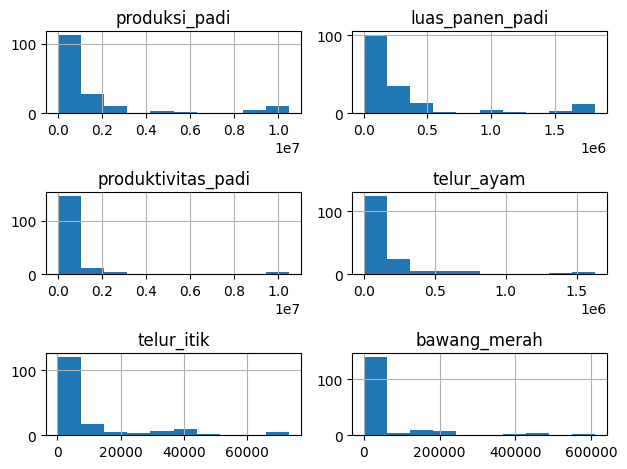

In [176]:
viz = cdf[['produksi_padi', 'luas_panen_padi', 'produktivitas_padi', 'telur_ayam', 'telur_itik', 'bawang_merah']]
viz.hist()
plt.tight_layout() 
plt.show()

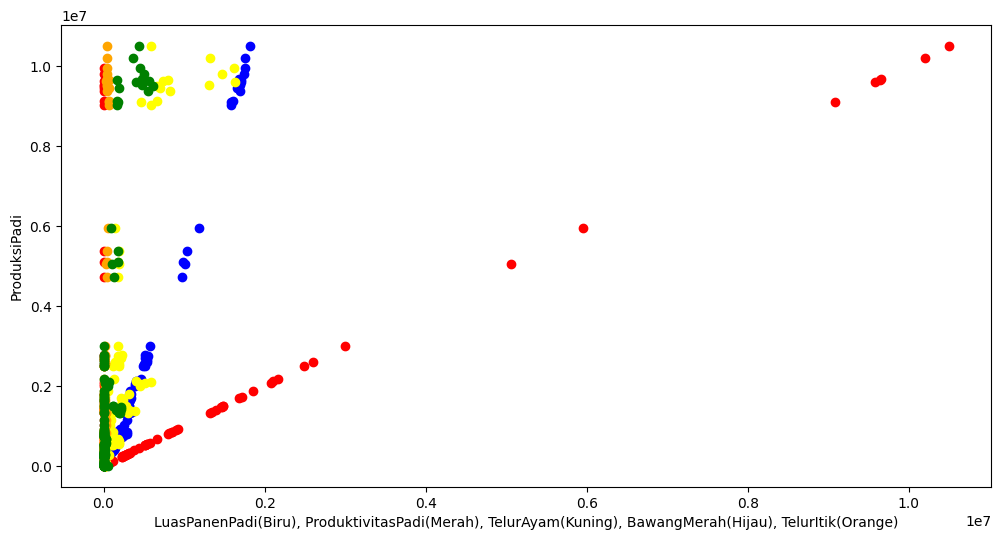

In [177]:
plt.subplots(figsize=(12, 6))
plt.scatter(cdf.luas_panen_padi, cdf.produksi_padi, color='blue')
plt.scatter(cdf.produktivitas_padi, cdf.produksi_padi, color='red')
plt.scatter(cdf.telur_ayam, cdf.produksi_padi, color='yellow')
plt.scatter(cdf.telur_itik, cdf.produksi_padi, color='orange')
plt.scatter(cdf.bawang_merah, cdf.produksi_padi, color='green')
plt.xlabel('LuasPanenPadi(Biru), ProduktivitasPadi(Merah), TelurAyam(Kuning), BawangMerah(Hijau), TelurItik(Orange)')
plt.ylabel('ProduksiPadi')
plt.show()

In [178]:
msk = np.random.rand(len(cdf)) < 0.7
train = cdf[msk]
test = cdf[~msk]

In [179]:
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['luas_panen_padi', 'produktivitas_padi', 'telur_ayam', 'bawang_merah', 'telur_itik']])
train_y = np.asanyarray(train[['produksi_padi']])
regr.fit(train_x, train_y)

print('Koefisien: ', regr.coef_)
print('Interspet: ', regr.intercept_)

Koefisien:  [[5.21665644 0.024348   0.15388618 1.07171781 2.72366744]]
Interspet:  [-118350.85081105]


In [180]:
test_x = np.asanyarray(test[['luas_panen_padi', 'produktivitas_padi', 'telur_ayam', 'bawang_merah', 'telur_itik']])
test_y = np.asanyarray(test[['produksi_padi']])

In [181]:
test_y_ = regr.predict(test_x)
print("Mean Absolute Error: %.2f " % mean_absolute_error(test_y_, test_y))
print("Mean Squared Error: %.2f " % mean_squared_error(test_y_, test_y))
print("Roots Mean Squared Error: %.2f " % math.sqrt(mean_squared_error(test_y_, test_y)))
print("R2-Score = %2f" % r2_score(test_y_, test_y))

Mean Absolute Error: 157089.95 
Mean Squared Error: 44590314922.06 
Roots Mean Squared Error: 211164.19 
R2-Score = 0.990157


### R2-Score Antara Luas Panen Padi - Produktivitas Padi - Produksi Padi

In [182]:
train_x = np.asanyarray(train[['luas_panen_padi']])
train_y = np.asanyarray(train[['produktivitas_padi']])
regr.fit(train_x, train_y)
print('Koefisien: ', regr.coef_)
print('Interspet: ', regr.intercept_)

Koefisien:  [[2.70331368]]
Interspet:  [-106278.37708203]


In [183]:
test_lpp = np.asanyarray(test[['luas_panen_padi']])
test_y_prodv = np.asanyarray(test[['produktivitas_padi']])
test_r2_1 = regr.predict(test_lpp)
print("R2-Score = %2f" % r2_score(test_r2_1, test_y_prodv))

R2-Score = -0.345498


In [184]:
train_x = np.asanyarray(train[['produktivitas_padi']])
train_y = np.asanyarray(train[['produksi_padi']])
regr.fit(train_x, train_y)

print('Koefisien: ', regr.coef_)
print('Interspet: ', regr.intercept_)

Koefisien:  [[0.83990281]]
Interspet:  [1078913.96734854]


In [185]:
test_prodv = np.asanyarray(test[['produktivitas_padi']])
test_y_prod = np.asanyarray(test[['produksi_padi']])

test_r2_2 = regr.predict(test_prodv)
print("R2-Score = %2f" % r2_score(test_r2_2, test_y_prodv))

R2-Score = -0.911630
